# TNM112 -- Lab 2

### Data generation
Look through the "data_generator.py" code to understand how the dataset is generated and plotted.

A dataset can be generated with a randomly selected subset of training images, and with a specified fraction used to formulate a validation set. Here, we use the MNIST dataset of handwritten digits.

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (54000, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


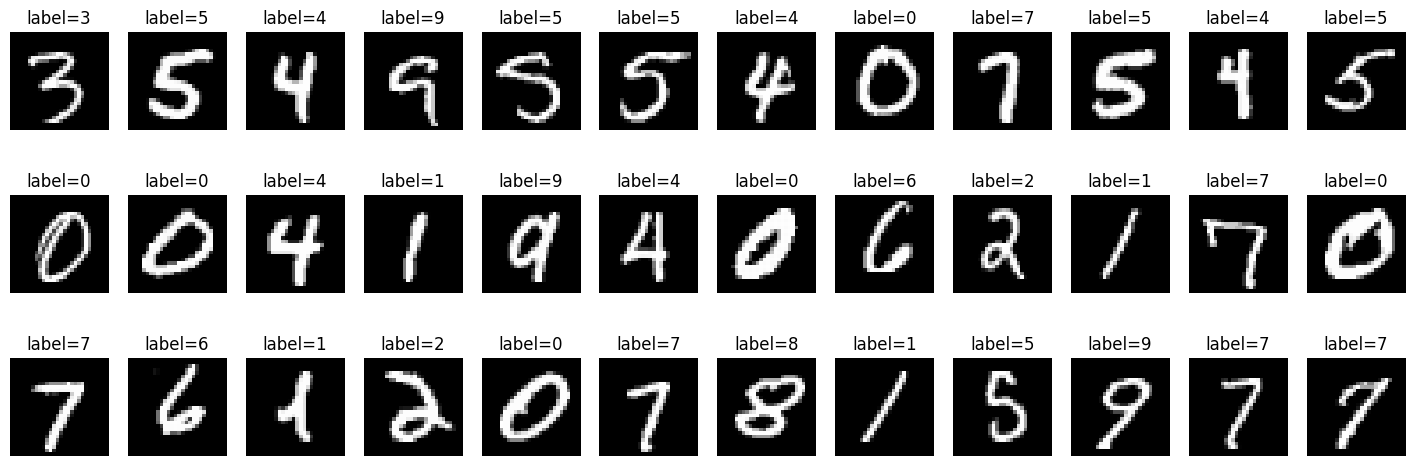

<Figure size 640x480 with 0 Axes>

In [2]:
import data_generator

data = data_generator.DataGenerator()
data.generate(dataset='mnist', N_valid=0.1)
data.plot()

### Keras CNN
A small CNN in Keras, trained with cross-entropy loss

We use the functions in 'util.py' to evaluate the model and plot the training progress.

c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         3,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,266 (16.66 KB)

 Trainable params: 4,266 (16.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6119 - loss: 1.2582 - val_accuracy: 0.9358 - val_loss: 0.2224
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9435 - loss: 0.1895 - val_accuracy: 0.9543 - val_loss: 0.1422
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9613 - loss: 0.1288 - val_accuracy: 0.9632 - val_loss: 0.1157
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9675 - loss: 0.1051 - val_accuracy: 0.9695 - val_loss: 0.0967
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9727 - loss: 0.0891 - val_accuracy: 0.9708 - val_loss: 0.0992
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9757 - loss: 0.0806 - val_accuracy: 0.9720 - val_loss: 0.0871
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9763 - loss: 0.0752 - val_accuracy: 0.9757 - val_loss: 0.0790
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9780 - loss: 0.0683 - val_accuracy: 0.

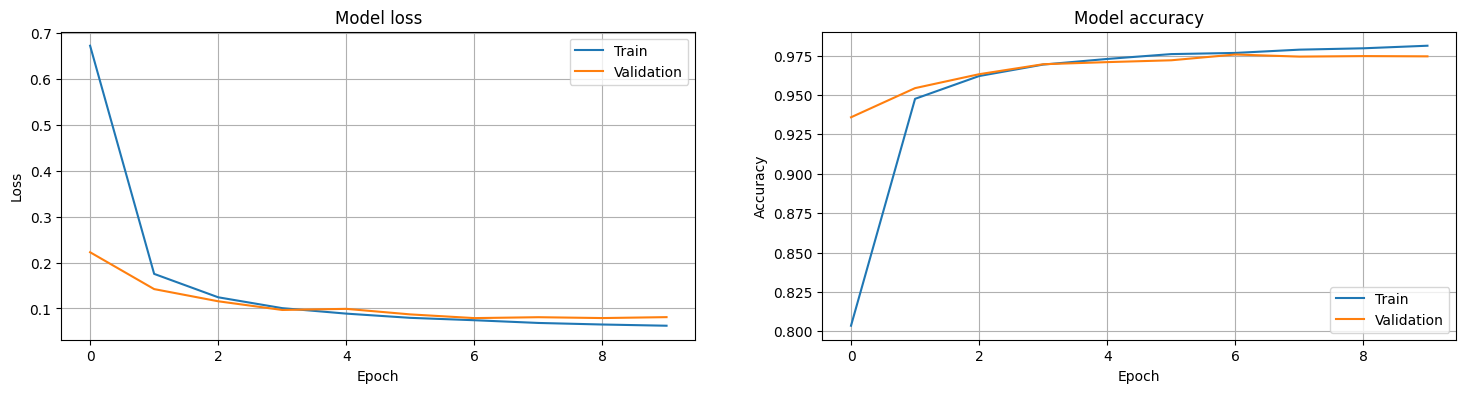

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import util

keras.backend.clear_session()

model = keras.Sequential()
model.add(layers.InputLayer(input_shape=data.x_train.shape[1:]))
model.add(layers.Conv2D(4, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(data.K, activation='softmax'))
model.summary()

opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
log = model.fit(data.x_train, data.y_train_oh, batch_size=128, epochs=10, 
                validation_data=(data.x_valid, data.y_valid_oh), verbose=True)

util.evaluate(model, data, final=True)
util.plot_training(log)

### Our CNN

#### Task 1
Implement the following functions in cnn.py: 'activation', 'conv2d_layer', 'pool2d_layer', 'flatten_layer', 'dense_layer', and 'evaluate'. Additionally, compute the number of weights in the model, in the function 'setup_model'.

For the 'activation' and 'dense_layer' functions you can use code that you wrote in Lab 1. For the 'evaluate' function you can use the code from Lab 1 for the accuracy. However, now we have trained with the cross-entropy loss, so you should evaluate this loss function through our CNN.

When you have finished the implementation, you should be able to run this code and get the same result as with the Keras model above. However, our code is not optimized, nor parallelized, so it will be rather slow to process the full dataset. In order to facilitate comparisons when you implement the functions, please have a look in the next cell below. 

In [4]:
import importlib
import cnn
importlib.reload(cnn)

# Get the weight matrices and biases of the trained Keras model
W, b, lname = util.get_weights(model)

# This is our implementation of a CNN, which we set to use the dataset we generated
cnn = cnn.CNN(data, verbose=True)

# Assign the weights and biases to the CNN and specify the activation function
cnn.setup_model(W, b, lname, activation='relu')

# Evaluate the model (accuracy on the training and test data)
cnn.evaluate()

Number of model weights:  4266
Model performance:
sample 0 of 54000
sample 1000 of 54000
sample 2000 of 54000
sample 3000 of 54000
sample 4000 of 54000
sample 5000 of 54000
sample 6000 of 54000
sample 7000 of 54000
sample 8000 of 54000
sample 9000 of 54000
sample 10000 of 54000
sample 11000 of 54000
sample 12000 of 54000
sample 13000 of 54000
sample 14000 of 54000
sample 15000 of 54000
sample 16000 of 54000
sample 17000 of 54000
sample 18000 of 54000
sample 19000 of 54000
sample 20000 of 54000
sample 21000 of 54000
sample 22000 of 54000
sample 23000 of 54000
sample 24000 of 54000
sample 25000 of 54000
sample 26000 of 54000
sample 27000 of 54000
sample 28000 of 54000
sample 29000 of 54000
sample 30000 of 54000
sample 31000 of 54000
sample 32000 of 54000
sample 33000 of 54000
sample 34000 of 54000
sample 35000 of 54000
sample 36000 of 54000
sample 37000 of 54000
sample 38000 of 54000
sample 39000 of 54000
sample 40000 of 54000
sample 41000 of 54000
sample 42000 of 54000
sample 43000 of 5

### Evaluation of our CNN layers

#### Task 1
As part of the implementation of the different layers in 'cnn.py', you can use the below code to compare the output of a randomly initialized Keras model and our CNN, for a single image. This is fast to compute, which will be convenient to check that your layers are correctly implemented.

In [5]:
import numpy as np
import cnn
importlib.reload(cnn)

# Secify a test layer for comparison: 'conv', 'pool', 'flatten', or 'dense'
test_layer = 'conv'

keras.backend.clear_session()

# Keras model and input layer
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=data.x_train.shape[1:]))

# Test conv layer
#   - We apply normal initialization to the bias also,
#     otherwise it would be difficult to see the impact
#     of how you apply the bias (it is initialized to 0 by default)
if test_layer == 'conv':
    model.add(layers.Conv2D(4, kernel_size=(3, 3), 
                            activation='relu', padding='same',
                            bias_initializer='normal'))
    
    # You could also test to add a second convolutional layer, to check
    # that your network maps correctly from the output channels of the
    # previous layer, to the channels of this layer
    model.add(layers.Conv2D(4, kernel_size=(3, 3), 
                           activation='relu', padding='same',
                           bias_initializer='normal'))

# Test pooling layer
elif test_layer == 'pool':
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Test flattening layer
elif test_layer == 'flatten':
    model.add(layers.Flatten())

# Test dense layer
#   - We need to first flatten the image input to apply a dense layer
#   - Make sure that your flatten layer works before testing the dense layer
elif test_layer == 'dense':
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax',
                           bias_initializer='normal'))

# Test data point (you could select any other image if you want)
x = data.x_train[0]

# Keras prediction. We need ta add an extra axis, 
# since the model can run over multiple datapoints. We 
# would need this in our model also if we use used the
# 'feedforward' function instead of the 'feedforward_sample'
y1 = model.predict(x[np.newaxis,:,:,:], verbose=False)

# Prediction with our network
W, b, lname = util.get_weights(model)  # Get the Keras model weights
cnn = cnn.CNN(data)
cnn.setup_model(W, b, lname, activation='relu') # Assign weights to our model
y2 = cnn.feedforward_sample(x) # Feedforward of one single sample

print('Evaluation of %s layer:'%test_layer)

# Check that the dimensionality is correct. The Keras
# model will have an extra first dimension due to the
# batch processing
print('\tShape of Keras output:  ', y1.shape)
print('\tShape of our output:    ', y2.shape)

# Print the absolute sum of output from the Keras
# model and our model. These should be the same if the
# implementation is correct
print('\tAbs sum of Keras model: ', np.sum(np.abs(y1)))
print('\tAbs sum of our model:   ', np.sum(np.abs(y2)))

# Print the absolute difference between the Keras
# model and our model. This should be very close
# to 0 if your implementation is correct. It could be
# a very minor difference due to numerical differences 
# (e.g., difference in precision used)
print('\tAbs difference:         ', np.sum(np.abs(y1-y2)))

Number of model weights:  188
Evaluation of conv layer:
	Shape of Keras output:   (1, 28, 28, 4)
	Shape of our output:     (28, 28, 4)
	Abs sum of Keras model:  219.85934
	Abs sum of our model:    219.85933774424245
	Abs difference:          3.437060781308343e-05


c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### MNIST with limited training data
#### Task 2
In this experiment, we select a random subset from MNIST, with only 128 images. This is a very minimal dataset, but it is interesting to see how overfitting can be prevented with regularization strategies.

Your task is to expand the given network with different regularization strategies. You are free to choose which combination of strategies you want to use, for example augmentation layers, dropout, weight decay, batch normalization, etc. You can also expand the network with more layers, strided convolutions, or add skip-connections to facilitate optimization. Moreover, you can experiment with the number of training epochs and the batch size.

Also, note that now we have specified the Keras network in a sligthly different way. We explicitly formulate the input and output to the different layers. One motiviation for this is that it is easier if we want to, e.g., add skip-connections (checkout the layers.Add() layer in Keras).

During your development, you test the performance on the validation set (util.evaluate with the flag final=False). When you have found a good setup, run evaluation on the test set (final=True). Do this for at least 5 runs and report the average and the variance across models. Since the subset of 128 images is randomly selected and the optimization is stochastic, you will get slightly different values each time. Thus, averaging is important to get a robust indication of your model's performance. You can do this manually, or you can setup a for-loop to run a sequence of trainings, where you log the evaluation results for each model.

For the final results, you should aim at having an average accuracy of at least 90% (which is quite good considering that we are only training on 128 images).

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,930 (81.76 KB)

 Trainable params: 20,930 (81.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.1250 - loss: 2.3234
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1302 - loss: 2.3087
Epoch 3/150


c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1458 - loss: 2.3013
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1406 - loss: 2.2867
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1302 - loss: 2.2872
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1406 - loss: 2.2873
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1458 - loss: 2.2960
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1562 - loss: 2.2708
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1302 - loss: 2.2842
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1562 - loss: 2.2595 - val_accuracy: 0.1143 - val_loss: 2.3018
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1667 - loss: 2.2614
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1354 - loss: 2.2730
Epoch 13/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1667 - loss: 2.2498
Epoch 14/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38m

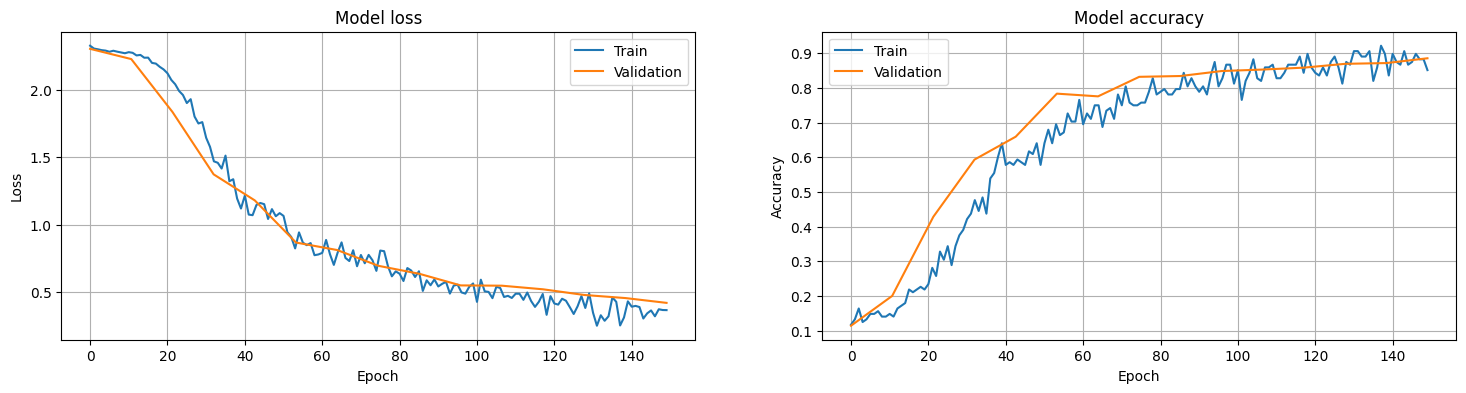

Model performance:
	Train loss:          0.1637
	Train accuracy:      99.22
	Test loss:           0.3678
	Test accuracy:       90.38
Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,930 (81.76 KB)

 Trainable params: 20,930 (81.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1354 - loss: 2.2991
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1458 - loss: 2.2923
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1510 - loss: 2.2753
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1823 - loss: 2.2332
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1615 - loss: 2.2408
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1562 - loss: 2.2232
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1823 - loss: 2.1936
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2083 - loss: 2.1696
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2708 - loss: 2.1574
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3125 - loss: 2.1513 - val_accuracy: 0.3970 - val_loss: 2.2276
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3021 - loss: 2.1204
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━

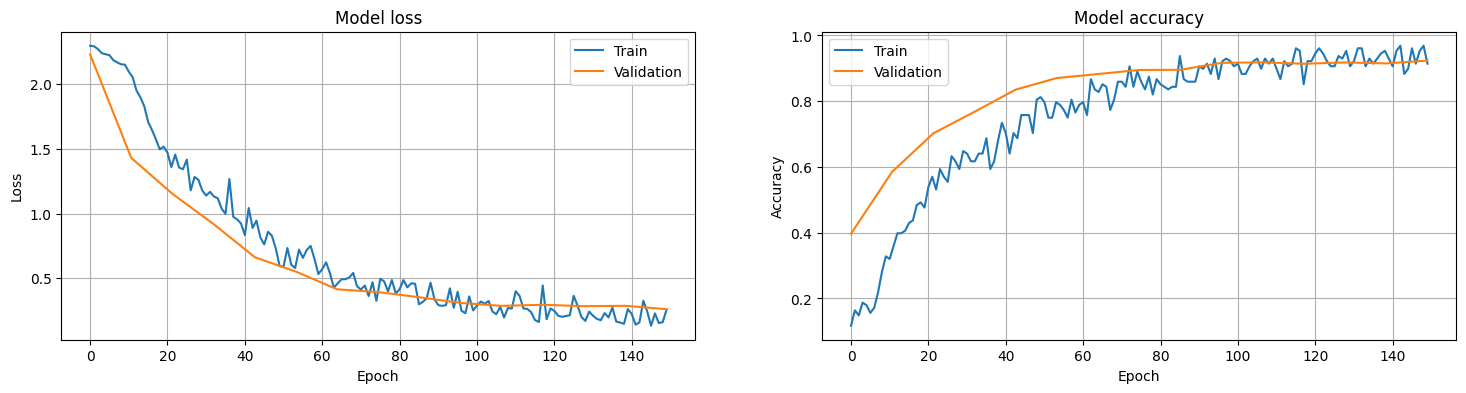

Model performance:
	Train loss:          0.0556
	Train accuracy:      100.00
	Test loss:           0.2415
	Test accuracy:       93.04
Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,930 (81.76 KB)

 Trainable params: 20,930 (81.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0990 - loss: 2.3773
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0677 - loss: 2.3214
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1406 - loss: 2.3044
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1250 - loss: 2.3055
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1562 - loss: 2.2889
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1458 - loss: 2.2814
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1510 - loss: 2.2859
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1354 - loss: 2.2854
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1354 - loss: 2.2745
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1302 - loss: 2.2893 - val_accuracy: 0.0995 - val_loss: 2.3049
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1615 - loss: 2.2731
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━

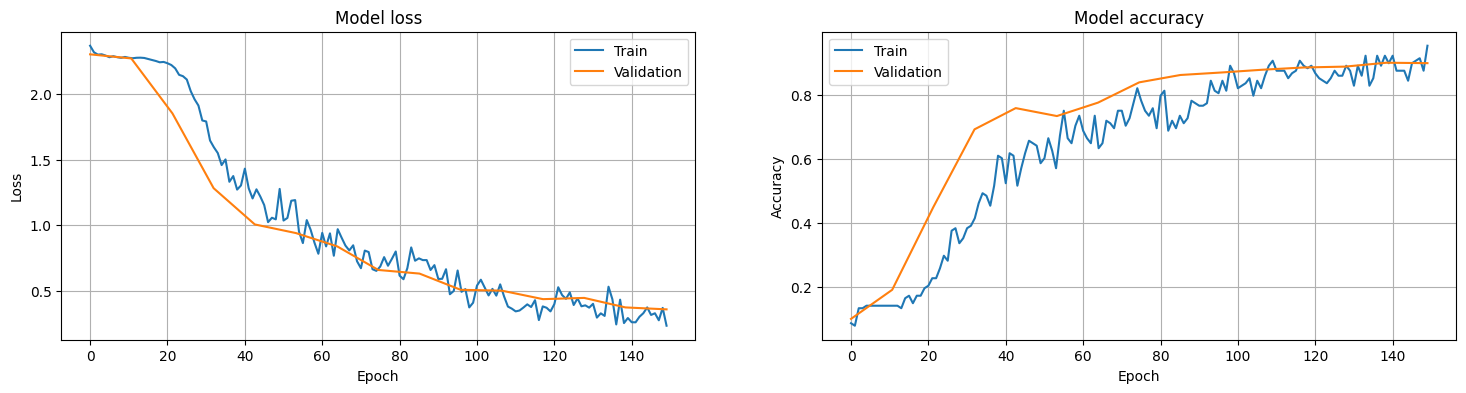

Model performance:
	Train loss:          0.1128
	Train accuracy:      99.22
	Test loss:           0.3284
	Test accuracy:       90.83
Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,930 (81.76 KB)

 Trainable params: 20,930 (81.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1354 - loss: 2.3237
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1615 - loss: 2.2739
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1250 - loss: 2.2823
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1406 - loss: 2.2554
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1615 - loss: 2.2493
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1615 - loss: 2.2449
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1615 - loss: 2.2580
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1719 - loss: 2.2162
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1615 - loss: 2.2520
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1302 - loss: 2.2266 - val_accuracy: 0.1085 - val_loss: 2.3092
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1510 - loss: 2.2271
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━

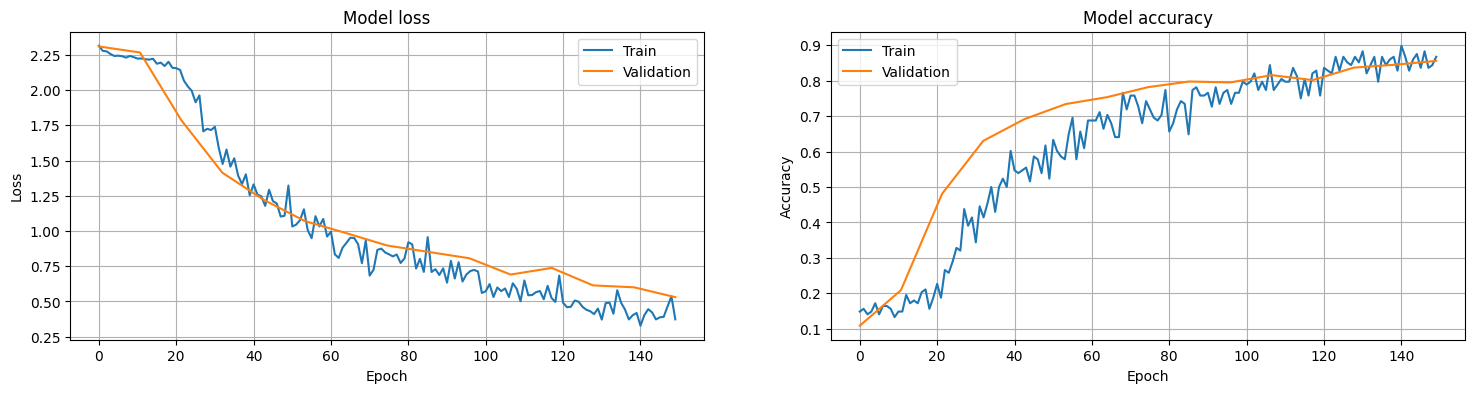

Model performance:
	Train loss:          0.2207
	Train accuracy:      96.09
	Test loss:           0.5013
	Test accuracy:       86.00
Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,930 (81.76 KB)

 Trainable params: 20,930 (81.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0990 - loss: 2.2939
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1667 - loss: 2.2427
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1615 - loss: 2.2499
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1719 - loss: 2.2161
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1875 - loss: 2.2167
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1771 - loss: 2.2425
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2083 - loss: 2.2176
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1875 - loss: 2.2283
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2240 - loss: 2.1870
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2031 - loss: 2.1784 - val_accuracy: 0.1760 - val_loss: 2.2945
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2031 - loss: 2.2024 
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━

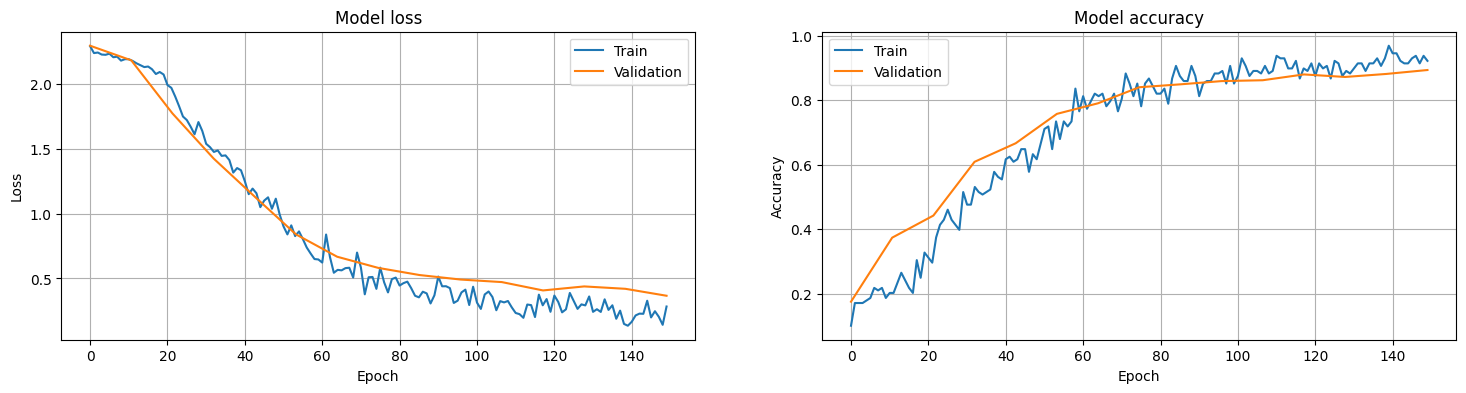

Model performance:
	Train loss:          0.0828
	Train accuracy:      98.44
	Test loss:           0.3385
	Test accuracy:       90.16


Final Results over 5 runs:
Mean Accuracy: 0.9008
Variance in Accuracy: 0.0005


In [46]:
from keras import regularizers
from keras.callbacks import EarlyStopping


# A block of convolutional layers followed by max pooling
def conv_block(x, N, channels, kernel_size, activation, padding='same', weight_decay=0.001, dropout_rate=0.3):
    for i in range(N):
        x = layers.Conv2D(channels, kernel_size=kernel_size, activation=activation, padding=padding, kernel_regularizer=regularizers.l2(weight_decay))(x)
        #x = layers.BatchNormalization()(x) 
        x = layers.Dropout(dropout_rate)(x)  # Add dropout after the convolutions
    return layers.MaxPooling2D(pool_size=(2, 2))(x)
    
epochs = 150
batch_size = 64

# ------ Added changes to get acc: 91.17% -------
# * Weight_decay, 0.00005
# * epochs: 150
# * batch_size: 64
# * drop-out: 0.1 -> 0.2 -> 0.25
# * datagen: 15 - 0.1 - 0.1 - 0.1 - 0.1

# For setting up averaging over multiple training runs
K = 5
acc = np.zeros((K,2))

for k in range(K):

    # MNIST with 128 randomly selected training images
    data = data_generator.DataGenerator()
    data.generate(dataset='mnist', N_train=128)

    keras.backend.clear_session()

    x      = layers.Input(shape=data.x_train.shape[1:])

    conv1  = conv_block(x, N=2, channels=8, kernel_size=(3,3), activation='relu', padding='same', weight_decay=0.00005, dropout_rate=0.1)
    conv2  = conv_block(conv1, N=2, channels=16, kernel_size=(3,3), activation='relu', padding='same', weight_decay=0.00005, dropout_rate=0.2)
    conv3  = conv_block(conv2, N=2, channels=32, kernel_size=(3,3), activation='relu', padding='same', weight_decay=0.00005, dropout_rate=0.25)
    flat1  = layers.Flatten()(conv3)

    y = layers.Dense(data.K, activation='softmax')(flat1)

    model = keras.models.Model(inputs=x, outputs=y)
    model.summary()

    opt = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Data augmentation
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1
    )

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation loss (or 'val_accuracy' if you want to monitor accuracy)
                                  patience=5,         # Number of epochs with no improvement after which training will be stopped
                                  restore_best_weights=True)  # Whether to restore model weights from the best epoch or the final weights

    log = model.fit(datagen.flow(data.x_train, data.y_train_oh, batch_size=batch_size), epochs=epochs, 
                    validation_data=(data.x_valid, data.y_valid_oh), validation_freq=10,  # We don't need to evaluate at each epoch
                    verbose=True, callbacks=[early_stopping])

    util.evaluate(model, data, final=False)
    util.plot_training(log)

    # When you are finished with hyper-parameter tuning, you should evaluate
    # your model on the test set, and average over 5 trainings. If you want
    # to do this automatically, you can setup a foor loop and store each evaluation
    acc[k,:] = util.evaluate(model, data, final=True)

# Calculate the average and variance across the 5 runs
mean_acc = np.mean(acc[:, 1])  # Use the second column for accuracy
var_acc = np.var(acc[:, 1])    # Use the second column for accuracy

# Print the final results
print(f"\n")
print(f"Final Results over {K} runs:")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Variance in Accuracy: {var_acc:.4f}")


### Tumor classification in digital pathology
#### Task 3
In this task, we will look at a more difficult task, using the PatchCamelyon dataset. This contains tissue samples from breast lymph nodes, which could either be healthy or contain tumor tissue, i.e. this is a binary classification problem. For this reason, it is valuable to also evaluate the AU-ROC, which can be passed to Keras as an evaluation metric, 'AUC'.

You are provided with the training and validation set. These have been cropped to 32x32 pixels, to make it a bit less resource demanding to train. The test set is also provided, but without labels.

Your task is to setup a Keras model to achieve the best possible performance on the validation set. You are free to choose how to do this, e.g., by means of regularization and network specifications. You can, for example, use your results from Task 2 as a starting point, but you should also think around how this problem differs from the MNIST classification. For example, in this case the orientation of images has no meaning, so you can randomly flip images both horizontally and vertically. You can also, e.g., explore augmentation by means of changing the image contrast and brightness.

When you are finished with your development, you should run the 'util.pred_test' (at the bottom of the cell), to produce a CSV file with predictions of the test set. The exported CSV file should be uploaded to the Kaggle challenge, as described in the lab information. You need to train the model and export a CSV file 5 times, in order to have a good estimate for your model's performance. There are no requirements on how well your model should perform, as long as it is well above random guessing (50% accuracy).

Data specification:
	Dataset type:           patchcam
	Number of classes:      2
	Number of channels:     3
	Training data shape:    (100000, 32, 32, 3)
	Validation data shape:  (32768, 32, 32, 3)
	Test data shape:        (32768, 32, 32, 3)


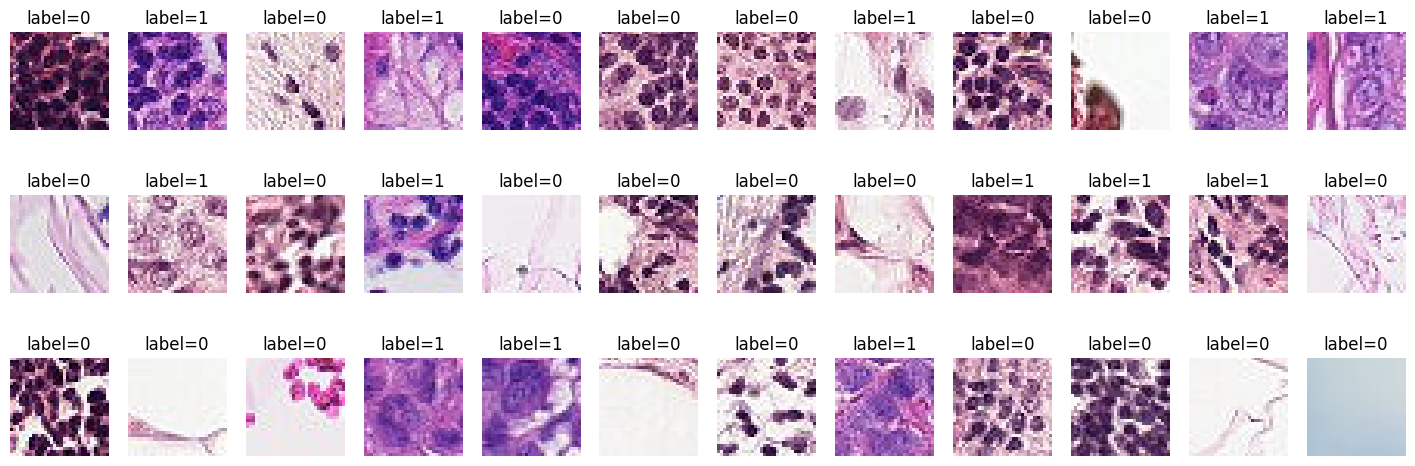

<Figure size 640x480 with 0 Axes>

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         6,146 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,146 (24.01 KB)

 Trainable params: 6,146 (24.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6081 - accuracy: 0.5844 - loss: 0.7029 - val_AUC: 0.7057 - val_accuracy: 0.6530 - val_loss: 0.6308
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.6766 - accuracy: 0.6303 - loss: 0.6462 - val_AUC: 0.7224 - val_accuracy: 0.6501 - val_loss: 0.6160
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.6966 - accuracy: 0.6459 - loss: 0.6367 - val_AUC: 0.7386 - val_accuracy: 0.6739 - val_loss: 0.6059
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7230 - accuracy: 0.6673 - loss: 0.6193 - val_AUC: 0.7516 - val_accuracy: 0.6846 - val_loss: 0.5998
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7294 - accuracy: 0.6713 - loss: 0.6156 - val_AUC: 0.7572 - val_accuracy: 0.6935 - val_loss: 0.5933
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7365 - accuracy: 0.6796 - loss: 0.6107 - val_AUC: 0.7252 - val_accuracy: 0.6585 - val_loss: 0.6292
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 

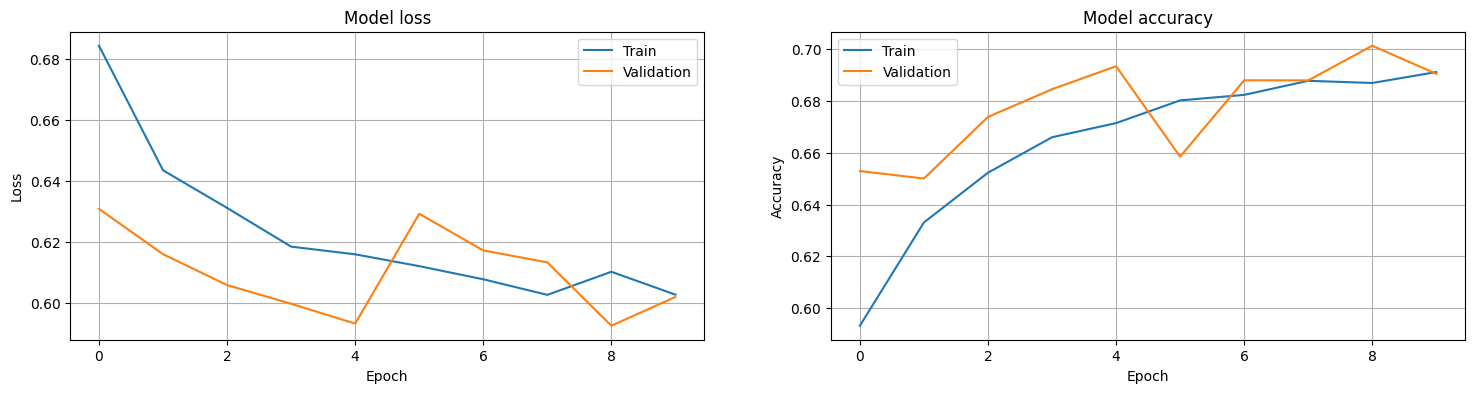

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import util
import data_generator
    
epochs = 10
batch_size = 128

# Load the PatchCamyleon dataset
# In this dataset, we don't have labels for the test set.
# Do your development by monitoring the validation performance,
# and when you are finished you will run predictions on the test
# set and produce a CSV file that you can upload to Kaggle.
data = data_generator.DataGenerator()
data.generate(dataset='patchcam')
data.plot()

keras.backend.clear_session()

# TODO: Build your network here
x = layers.Input(shape=data.x_train.shape[1:])
flat1  = layers.Flatten()(x)
y = layers.Dense(data.K, activation='softmax')(flat1)

model = keras.models.Model(inputs=x, outputs=y)
model.summary()

opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
log = model.fit(data.x_train, data.y_train_oh, batch_size=batch_size, epochs=epochs, 
                validation_data=(data.x_valid, data.y_valid_oh), validation_freq=1,
                verbose=True)

util.evaluate(model, data)
util.plot_training(log)

# TODO: When you have finished your model development, you should 
# run inference on the test set and export a CSV file that can be 
# uploaded to Kaggle
#util.pred_test(model, data, name='your_submission.csv')